# Introduction to Working with Filterbank Files
by Umran Haji, Undergraduate Research Intern

---

Welcome! In this tutorial I will demonstrate the basics of working with filterbank (`.fil`) files using [blimpy](https://github.com/UCBerkeleySETI/blimpy). Breakthrough Listen data from the Green Bank Telescope (GBT) is stored in filterbank format, so these skills will be of paramount importance to anyone who intends to work with such data for analysis and visualization purposes.

## 1. What are filterbank files and `blimpy`? 

Filterbank files are a binary data storage format which we use to store time series of power spectra. If that sounds like a bunch of confusing jargon, all it means is that a filterbank file stores information about how the power being collected by the GBT at many different frequencies of light changes over time. In addition to the stored data, a filterbank file contains a header that includes information about observation parameters, such as the date/time of the observation, the name of the target observed, and many other useful values which we will discuss later.

Since filterbank is a binary format, if you were to open up one of these files in a text editor, you would not be able to read it; you would just see a bunch of binary gibberish. This is where `blimpy` steps in. It includes a host of functions that parse the binary text in a filterbank file, and even defines a class, `Waterfall`, which you can use to instantiate any `.fil` file for easy extraction of the data objects as numpy arrays. In addition to importing the functions and class from `blimpy` into Python, you can also run it on any filterbank file from the command line to quickly view header info, generate plots, and so on.

In this tutorial I will demonstrate how to use `blimpy` within the Python interpreter for all the most essential purposes, namely extracting header information, extracting data and frequency arrays, and generating plots. 


## 2. Some Fun Physics Background

First, it's worth taking a little bit of time to discuss the basics of how in the world we even end up with a filterbank file after pointing our telescope somewhere! If you're not a physics/astro person (e.g. a computer science major), this will hopefully distill and demystify the nature of power spectra so that you understand what you are actually working with. And even if you do study physics/astronomy, you may find the following discussion an enlightening synthesis of your physics knowledge if you have never really thought about the process end-to-end.

Light is nothing more than an oscillating set of fields of electric and magnetic force that "feed off" each other (due to [Maxwell's equations](https://en.wikipedia.org/wiki/Electromagnetic_radiation#Maxwell.E2.80.99s_equations)) and thereby can propagate through space together. All that means is, if you were to take a tiny electrically charged particle (or magnetically charged particle, if [magnetic monopoles](https://en.wikipedia.org/wiki/Magnetic_monopole) existed) and shine some light at it, the particle would oscillate up and down (or in some other fashion, depending on the <a href="https://en.wikipedia.org/wiki/Polarization_(waves)"> polarization of the light</a>). 

If instead of a single charged particle you have an extended material with lots of loosely-held charges running around, e.g. a metal, the oscillating electric field in the light wave results in an oscillating voltage (and therefore an oscillating current) within the material, just as if it was hooked up to an AC voltage source that alternated at the same frequency as the light wave. In simpler terms, the oscillating electric field pushes and pulls charges (read: electrons) around in the material in an oscillatory manner. <a href="https://en.wikipedia.org/wiki/Antenna_(radio)#/media/File:Dipole_receiving_antenna_animation_6_800x394x150ms.gif">Here is a great animation</a> of exactly this process, and this is more or less how a radio antenna actually works. By measuring how the voltage difference across the antenna changes over time, one can learn about the incoming electromagnetic wave; the amplitude of the voltage difference is related to the amplitude of the electric field in the light wave, and the frequency of the voltage oscillation is the frequency of the light wave!

This is roughly what is happening at the GBT. A telescope is essentially a huge "light bucket"; the GBT collects copious amounts of light with its 100-meter primary mirror and directs it to a radio receiver which is something like an antenna, and oscillating voltage differences are induced in the receiver (the details are more complicated, but that is the general picture).

The only problem is, the telescope is being bombarded by light of a million different frequencies, so it is not that simple; because a radio antenna "sees" light coming from a huge variety of sources, the oscillations caused by their electric fields superpose on top of one another, making an extremely complicated oscillation pattern in the voltage. Luckily, we have [Fourier analysis](https://en.wikipedia.org/wiki/Fourier_series)! Fourier's Theorem says that any continuous or "[piecewise continuous](https://en.wikipedia.org/wiki/Piecewise)" periodic function (such as an oscillation!) can be expressed as a sum of simple sinusoidal functions, each with its own amplitude and frequency. <a href="http://toxicdump.org/stuff/FourierToy.swf?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+hacker-news-feed-200+(Hacker+News+200)">Here is an amazing toy</a> (if it doesn't open, try a different browser) that lets you play around with this phenomenon; you can change the amplitudes of oscillations of a variety of given frequencies and observe how the oscillations add to create an amazing variety of shapes. 

Fourier's Theorem is hard to prove, but if you are mathematically inclined, with a little practice you too can [learn to compute the Fourier series for any elementary periodic function your heart desires!](http://www.stewartcalculus.com/data/CALCULUS%20Early%20Transcendentals/upfiles/FourierSeries5ET.pdf).

Fourier analysis is the greatest thing since before sliced bread (which wasn't first sold commercially until 98 years after Joseph Fourier's death) because of its implications in a huge variety of fields including observational astronomy. For our purposes, the upshot of Fourier analysis is that it allows any electromagnetic signal to be dissected into all of its component frequencies, each with its own amplitude, via an operation known as the "Fourier transform". Of course, doing it numerically, using observational data, is different from doing it for analytic functions, so computers have a numerical version known as a "fast Fourier transform" or FFT, but the basic idea is the same. If you have a plot of data points that shows "time" on the x-axis and "voltage difference" on the y-axis, for example, the FFT turns this into a plot that shows "frequency" on the x-axis and "amplitude" (or some related quantity such as "power") on y-axis. The resulting plot, in astronomical contexts, is known as a power spectrum.

The computers at GBT run FFTs on the so-called "raw voltage data" from an observation, and this is essentially how that data gets turned into our friend the filterbank file!

## 3. Loading in a Filterbank File + A First Look at Plots and Info

Most of the tools you will need for analyzing filterbank files are contained within the `Waterfall` class. To start out, clone the [Git repository](https://github.com/UCBerkeleySETI/blimpy) (or install with pip, by typing `pip install blimpy`). In my case, I have a `.fil` file in my working directory, so I just use the name of the file. You can also try downloading one of the files with File Type `filterbank` from the [Breakthrough Listen data archive](http://breakthroughinitiatives.org/opendatasearch).

In [2]:
import numpy as np
from scipy import signal
from blimpy.io import write_to_fil

In [3]:
from blimpy import Waterfall

filename = 'spliced_blc0001020304050607_guppi_57571_78180_HIP45653_0042.gpuspec.0002.h5'
#filename = 'blc00_guppi_57807_75725_DIAG_TRAPPIST1_0015.gpuspec.0001.fil'
fil = Waterfall(filename)

In [4]:
print(hasattr(fil,'freqs'))
print(dir(fil))

False
['_Waterfall__load_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_blob_dimensions', '_get_chunk_dimensions', '_init_alternate', '_update_header', 'beam_axis', 'blank_dc', 'calc_n_coarse_chan', 'calibrate_band_pass_N1', 'container', 'data', 'ext', 'file_header', 'file_shape', 'file_size_bytes', 'filename', 'freq_axis', 'get_freqs', 'grab_data', 'header', 'info', 'logger', 'n_channels_in_file', 'n_ints_in_file', 'plot_all', 'plot_kurtosis', 'plot_spectrum', 'plot_spectrum_min_max', 'plot_time_series', 'plot_waterfall', 'read_data', 'selection_shape', 'stokes_axis', 'time_axis', 'write_to_fil', 'write_to_hdf5']


### Waterfall Plots

Now that we have done that, there are several things we can look at. Remember that a filterbank file shows how power varies with frequency and time. As such, it contains many **time integrations** (a time integration is just a period of time over which the light is collected), and each integration has a **power spectrum** associated with it. The data contained in the filterbank file therefore has three dimensions: frequency, power, and time. So, if I wanted to display all of the data contained in the filterbank file in one visualization, I would show it as a waterfall plot, like this:

### Waterfall Plots

Now that we have done that, there are several things we can look at. Remember that a filterbank file shows how power varies with frequency and time. As such, it contains many **time integrations** (a time integration is just a period of time over which the light is collected), and each integration has a **power spectrum** associated with it. The data contained in the filterbank file therefore has three dimensions: frequency, power, and time. So, if I wanted to display all of the data contained in the filterbank file in one visualization, I would show it as a waterfall plot, like this:

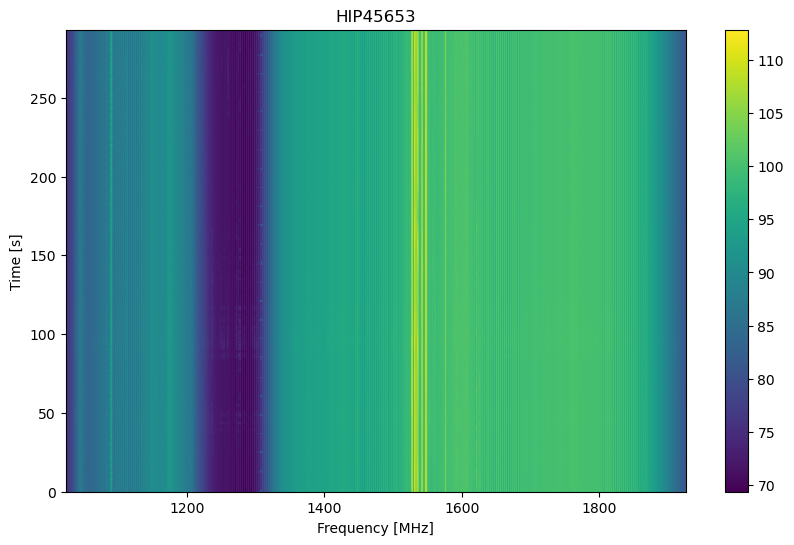

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
fil.plot_waterfall()
plt.show()

In [8]:
print(hasattr(fil,'freqs'))

True


This **waterfall plot** shows exactly what we said at the beginning of this tutorial: how the power at a certain frequency is varying over time, where time increases as you move down the vertical axis. The colors represent the power values.

It's called a waterfall plot because if you were seeing the data come in in real time, the colors would move vertically at constant speed. In this case they would move downward, as the most recent data is at the top of the plot.

If you wanted to zoom in on a frequency range, you can use the `f_start` and `f_stop` arguments. There are also a few other optional arguments detailed in `blimpy` which I will skip over here.

In [10]:
plt.figure(figsize=(10,6))
fil.plot_waterfall(f_start=1400, f_stop=1600)

In [11]:
print(hasattr(fil,'freqs'))

True


### Power Spectrum for a Given Integration

Now imagine you were to pull a horizontal slice of the waterfall plot out of the screen like pulling a card out of a deck, and flip it 90 degrees so that the edge of the card that is initially closest to you is now on top. You would then be looking at a **power spectrum** for one particular **integration**. It shows frequency on the x-axis and power on the y-axis. We can display a power spectrum using another function contained in `blimpy`. Let's choose to display the 100th integration (which would be indexed as 99 since the integration indices start at 0):

extracting integration 25...
extracting integration 99...
extracting integration 120...


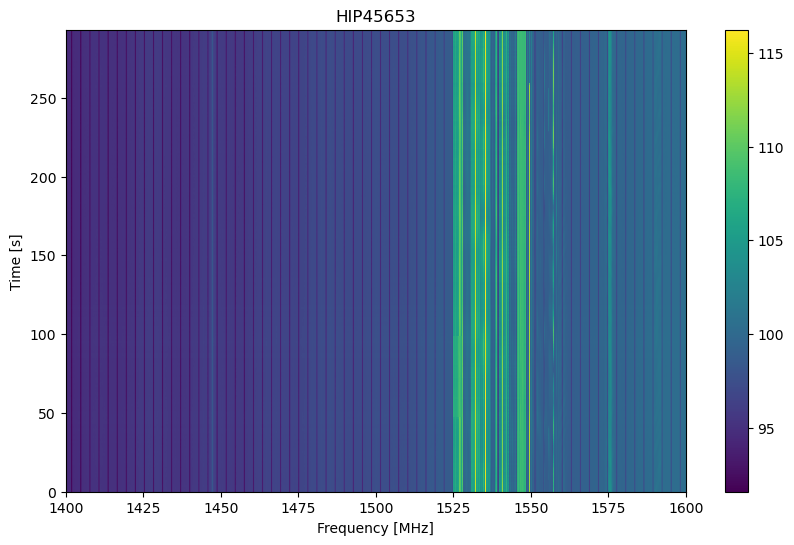

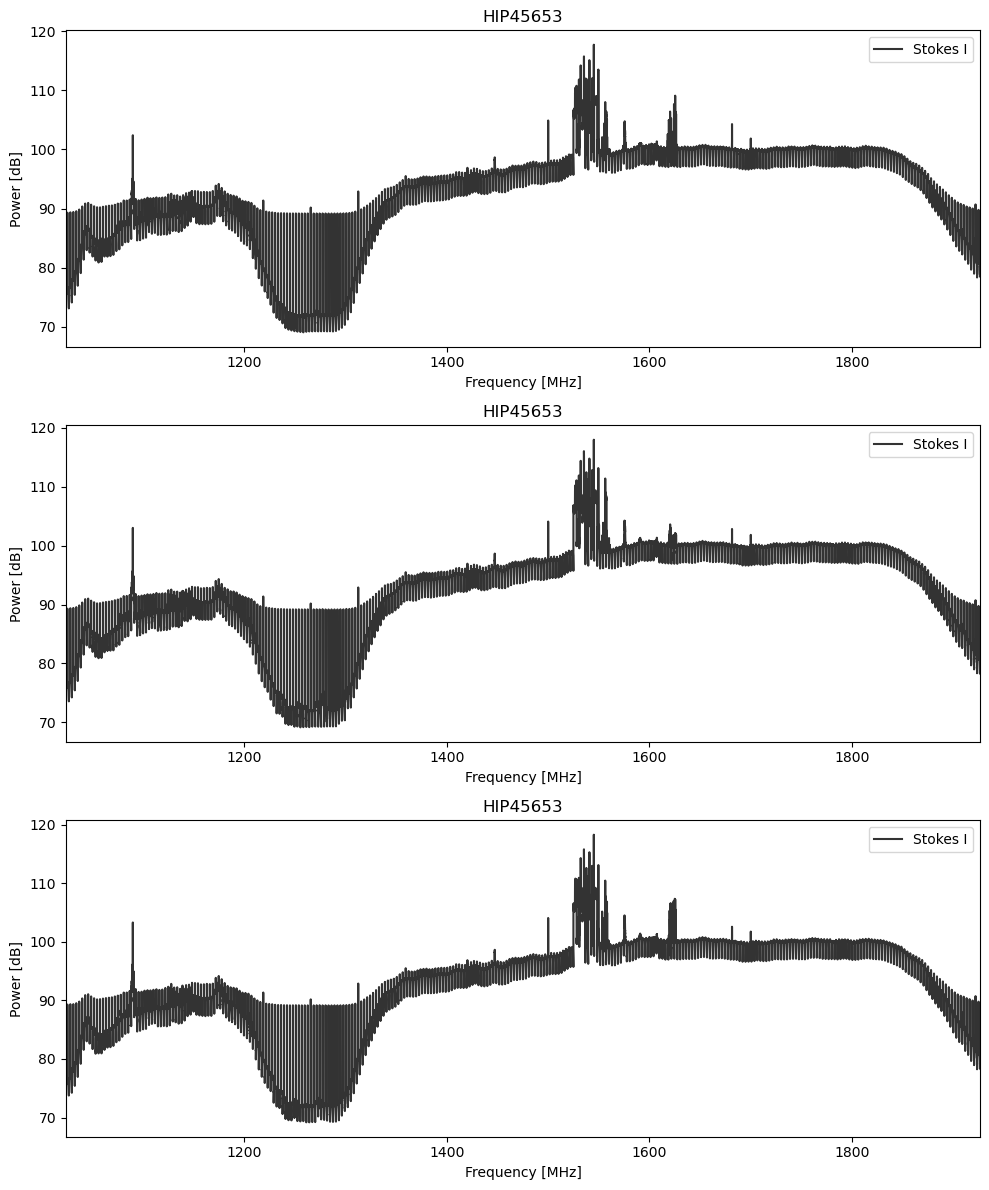

In [13]:
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
fil.plot_spectrum(t=25,logged = True) #Leaving arguments blank will cause it to show integration 0 by default
plt.subplot(3,1,2)
fil.plot_spectrum(t=99,logged = True) #Leaving arguments blank will cause it to show integration 0 by default
plt.subplot(3,1,3)
fil.plot_spectrum(t=120,logged = True) #Leaving arguments blank will cause it to show integration 0 by default

plt.tight_layout()
plt.show()

extracting integration 25...


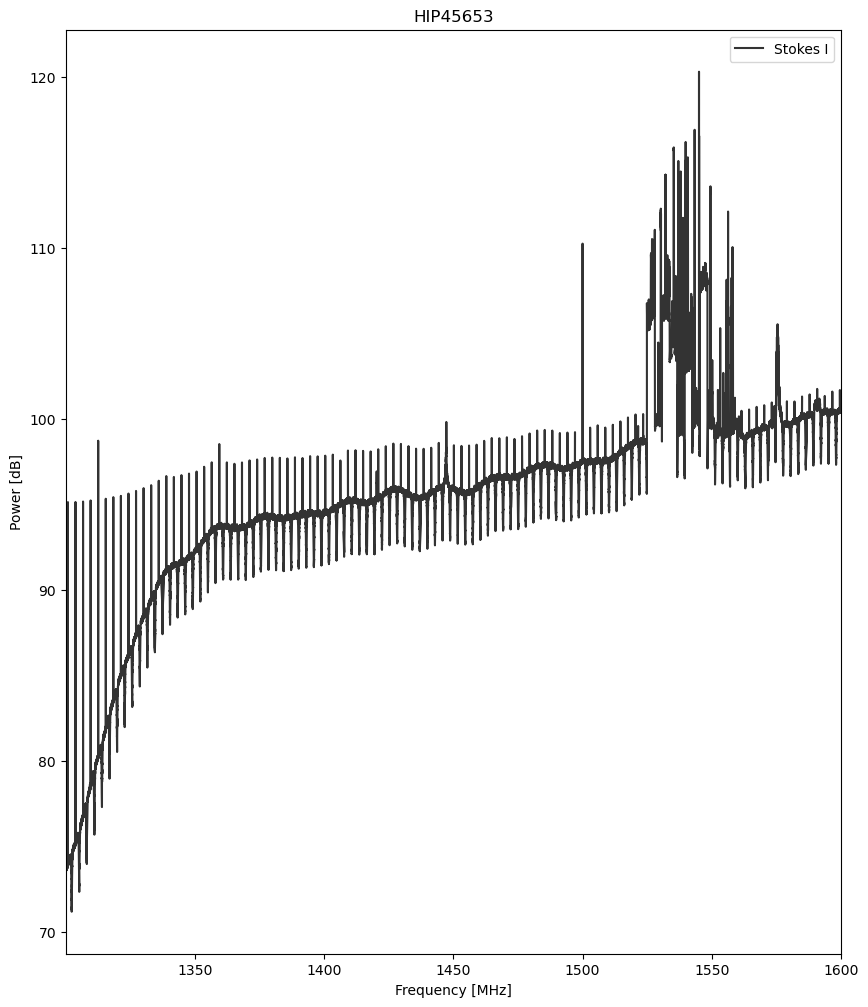

In [14]:
plt.figure(figsize=(10,12))

fil.plot_spectrum(t=25, f_start=1300, f_stop=1600, logged = True) #Leaving arguments blank will cause it to show integration 0 by default
plt.show()

You can ignore the evenly-spaced, equally-tall spikes throughout the spectrum; those are artifacts caused by [band-pass filters](https://en.wikipedia.org/wiki/Band-pass_filter) (they are also the cause of the dark vertical lines in the waterfall plot). 

We can also use the same arguments as before to zoom in on a region. A strong and well-known feature of interest here is the spike at approximately 1420 MHz; it is an emission line of hydrogen known as the [21-centimeter line](https://en.wikipedia.org/wiki/Hydrogen_line), on account of its wavelength which is approximately 21 cm.

extracting integration 99...


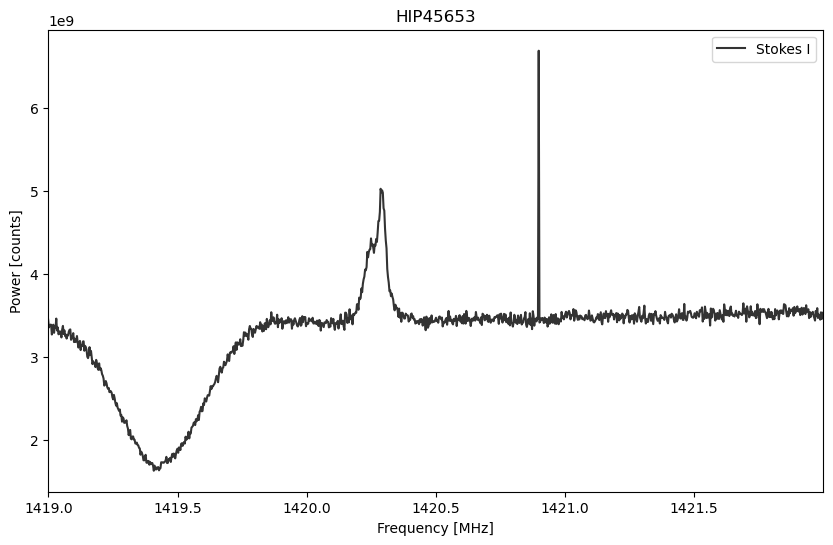

In [16]:
plt.figure(figsize=(10,6))
fil.plot_spectrum(t=99, f_start=1419, f_stop=1422)
plt.show()

### Header Information

We can use another function to easily print the header information from the file:

In [18]:
fil.info()


--- File Info ---
DIMENSION_LABELS :   ['frequency' 'feed_id' 'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                1926.26953125 MHz
            foff :         -0.00286102294921875 MHz
      machine_id :                               20
           nbits :                               32
          nchans :                           315392
            nifs :                                1
     source_name :                         HIP45653
         src_dej :                      7:04:22.902
         src_raj :                          9:18:21
    telescope_id :                                6
           tsamp :               1.0737418239999998
   tstart (ISOT) :          2016-07-02T21:43:00.000
    tstart (MJD) :               57571.904861111114
        za_start :                              0.0

Num ints in file :                              273
      File shape :                 (273, 1, 

There are many useful pieces of information here, which you wil probably use at some point or another. I'll explain the most important ones, but all the header keywords are detailed in `blimpy`:

- **`source_name`**: The name of the target observed. In this case it is HIP35136, a star listed in the [Hipparcos catalog](https://en.wikipedia.org/wiki/Hipparcos).
- **`tstart`**: The start date of the observation, in [Modified Julian Date](https://en.wikipedia.org/wiki/Julian_day) format
- **`src_raj`**: The [right ascension](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) of the target in hours:minutes:seconds.
- **`src_dej`**: The [declination](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) of the target in degrees:arcminutes:arcseconds.
- **`nchans`**: The number of channels (i.e. frequency bins)
- **`fch1`**: The center frequency of the first channel (i.e. the highest-frequency channel).
- **`foff`**: The bandwidth of each channel, in MHz. It is negative because the channels are numbered in increasing order as they decrease in frequency.



## 4. Getting Your Hands on the Actual Data

Now that I've showed you how to visualize the data and print the header info, I'll show you how to extract the data so that you can use it for analysis purposes.

### Extracting Frequency Bins

First let's get ahold of the values of the center frequencies of the channels. This is easy to do:

In [22]:
print(hasattr(fil,'freqs'))
print(dir(fil))

True
['_Waterfall__load_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_blob_dimensions', '_get_chunk_dimensions', '_init_alternate', '_update_header', 'beam_axis', 'blank_dc', 'calc_n_coarse_chan', 'calibrate_band_pass_N1', 'container', 'data', 'ext', 'file_header', 'file_shape', 'file_size_bytes', 'filename', 'freq_axis', 'freqs', 'get_freqs', 'grab_data', 'header', 'info', 'logger', 'n_channels_in_file', 'n_ints_in_file', 'plot_all', 'plot_kurtosis', 'plot_spectrum', 'plot_spectrum_min_max', 'plot_time_series', 'plot_waterfall', 'read_data', 'selection_shape', 'stokes_axis', 'time_axis', 'timestamps', 'write_to_fil', 'write_to_hdf5']


In [23]:
freqs = np.flip(fil.freqs)
print(freqs)
print(type(freqs))

[1023.92864227 1023.9315033  1023.93436432 ... 1926.2638092  1926.26667023
 1926.26953125]
<class 'numpy.ndarray'>


In [24]:
print(hasattr(fil,'freqs'))
print(dir(fil))

True
['_Waterfall__load_data', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_blob_dimensions', '_get_chunk_dimensions', '_init_alternate', '_update_header', 'beam_axis', 'blank_dc', 'calc_n_coarse_chan', 'calibrate_band_pass_N1', 'container', 'data', 'ext', 'file_header', 'file_shape', 'file_size_bytes', 'filename', 'freq_axis', 'freqs', 'get_freqs', 'grab_data', 'header', 'info', 'logger', 'n_channels_in_file', 'n_ints_in_file', 'plot_all', 'plot_kurtosis', 'plot_spectrum', 'plot_spectrum_min_max', 'plot_time_series', 'plot_waterfall', 'read_data', 'selection_shape', 'stokes_axis', 'time_axis', 'timestamps', 'write_to_fil', 'write_to_hdf5']


As you can see, we get the frequencies in MHz in a 1-D `numpy` array.

### Extracting Power Data

Now let's take a look at the object that contains the actual power values:

In [27]:
data = np.flip(fil.data)
print(data.shape)
print(type(data))

(273, 1, 315392)
<class 'numpy.ndarray'>


The power values are stored in a 3-D `numpy` array. The first dimension corresponds to the number of integrations in the file (notice from the header info above that "`num ints in file:`" reads 273). Meanwhile the third dimension corresponds to the number of frequency channels (notice in the header that "`nchans:`" reads 65536).

So, by picking a value along the zeroth axis (i.e. first dimension) of the array, I can extract the power values associated with that integration. The array of power values will have length 65536, since there is one power value associated with each channel.

For example, suppose I want to get the power values from integration 100 (index 99) as before. For this I simply do:

In [29]:
powers100 = data[99]
print(powers100)
powers100 = powers100[0]
print(powers100)
print(len(powers100))

[[20215600. 20148346. 19961276. ... 65163056. 65248284. 63667312.]]
[20215600. 20148346. 19961276. ... 65163056. 65248284. 63667312.]
315392


(The extra 0 index at the end is necessary to isolate the values in a 1-D array).

Now we have the power values for integration 100, and sure enough, the array has the expected length. If you were to find the length of the `freqs` array, you would see that it is also 65536.

These power values line up with the values of the frequencies. For example, from the `freqs` array and the `powers100` array we see that in the first channel, which is centered at `1313.96627426` MHz, the power value is `7.93240480e+07`.

We can now do whatever we like with these frequencies and power values. For demonstration, I'll plot the values for integration 100, just to show that we get the same plot as when we called `fil.plot_spectrum(t=99)`:

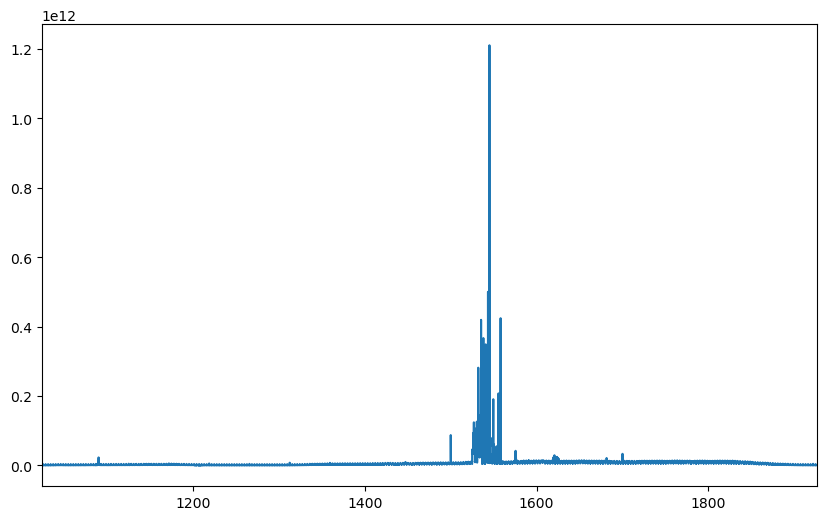

In [31]:
plt.figure(figsize=(10,6))
plt.plot(freqs, powers100)
plt.xlim(freqs[0], freqs[-1])
plt.show()

### Extracting Header Parameters + A Word of Advice

Whereas the `self.info()` method just prints the header information, use `self.header` to get the header in the form of a Python dictionary:

In [33]:
header = fil.header
print(header)

{'DIMENSION_LABELS': array(['frequency', 'feed_id', 'time'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 1926.26953125, 'foff': -0.00286102294921875, 'machine_id': 20, 'nbits': 32, 'nchans': 315392, 'nifs': 1, 'source_name': 'HIP45653', 'src_dej': <Angle 7.07302833 deg>, 'src_raj': <Angle 9.30583333 hourangle>, 'telescope_id': 6, 'tsamp': 1.0737418239999998, 'tstart': 57571.904861111114, 'za_start': 0.0}


Testing out the extraction of a parameter:

In [35]:
nchans = header['nchans']
print(nchans)

315392


Now, here is a word of advice regarding extracting header information: If you ever find yourself running some sort of code that is only interested in the header information of filterbank files and doesn't care about the data itself (say, for example, you are running some code that checks filterbank files to see if a value in their headers fulfills a certain condition), you should **NOT** use the `self.header` method contained in the `Waterfall` class. 

The reason why you should not do this is because, when you instantiate a file as a member of the `Waterfall` class, `blimpy` will parse the *entire* file, including not only the header but also the data. The small amount of extra time required for this will compound dramatically if you are running something on a large number of filterbank files, and especially if you are working with large files (the files that have all the pieces of the band spliced together, for example, are half a gigabyte in size at minimum).

If you are interested only in the header information of a filterbank file, you should instead use the `read_header` function from `blimpy`, as it parses the header from binary without parsing the data arrays:

The resultant dictionary contains all the same information as the one you obtain from `self.header`.

## 5. Miscellaneous Helpful Functions

Here are some miscellaneous functions that I have written during my time with Breakthrough Listen that you may find useful:

In [39]:
"""
All these functions show the required modules imported within the function. This is simply to show as
clearly as possible which modules are required by each function. Of course, in general you should 
import all modules at the top of your script.
"""
from blimpy import Waterfall


def maxfreq(file):
    """Return central frequency of the highest-frequency bin in a .fil file.""" 
    
    fil = Waterfall(file)
    return fil.header['fch1']

def minfreq(file):
    """Return central frequency of the lowest-frequency bin in a .fil file"""
    
    fil = Waterfall(file)
    fch1 = fil.header['fch1']
    nchans = fil.header['nchans']
    ch_bandwidth = fil.header['foff']
    return fch1 + nchans*ch_bandwidth

def currentMJD():
    """Returns current MJD including decimals."""
    
    from astropy.time import Time
    print(Time.now().mjd) 

def AA(file): 
    """Returns Alt-Az coordinates (deg) for a given GBT .fil file.
    
    Args:
        file (str): .fil file
        
    Returns:
        altazdict (dict): Dictionary with alt and az in degrees.
    """
    
    from astropy import units as u
    from astropy.time import Time
    from astropy.coordinates import EarthLocation, SkyCoord, AltAz

    fil = Waterfall(file)
    
    GreenBank = EarthLocation(lat=38.4322*u.deg, lon=-79.8398*u.deg) #Western longitudes are negative
    MJD = fil.header['tstart']
    ra = fil.header['src_raj']
    dec = fil.header(file)['src_dej']
    target = SkyCoord(ra, dec)
    altaz = target.transform_to(AltAz(location=GreenBank, obstime=Time(MJD, format='mjd')))
    altazdict = { 'alt' : altaz.alt.degree, 'az' : altaz.az.degree }
    return altazdict

def totalpower(file, integration, fmin, fmax): 
    
    """Use Simpson's rule numerical integration to find total power between 
    given freq bounds, for given time integration.
    
    Args:
        file (str): .fil file
        integration (int): .fil file integration number to analyze
        fmin (float): Lower freq bound
        fmax (float): Upper freq bound
        
    Returns:
        totalpower (float): total power (from Simpson's rule)
                            under the power spectrum curve 
                            between fmin and fmax
    """
    
    import numpy as np
    from scipy.integrate import simps
    from blimpy import Waterfall
    
    #Get data
    fil = Waterfall(file)
    freqs = np.array(fil.freqs)
    data = np.array(fil.data[integration][0])
    
    #Check for valid bounds
    maxfreq = fil.header['fch1']
    nchans = fil.header['nchans']
    ch_bandwidth = read_header(file)['foff']
    minfreq = maxfreq + nchans*ch_bandwidth
    if fmin < minfreq or fmax > maxfreq:
        raise ValueError("One of your freq constraints is out of the freq range of this filterbank file.") 
    
    #Get freqs and power values from desired range
    idx = np.where(np.logical_and(freqs >= fmin, freqs <= fmax))
    newfreqs = freqs[idx]
    newdata = data[idx]
    
    #Integrate
    totalpower = simps(x=newfreqs, y=newdata)
    return totalpower

Congratulations! You now have everything you need to start working with filterbank data!

## 6. RFI determination

In [42]:
import numpy as np
import itertools, json
from astropy.stats.sigma_clipping import sigma_clip
from scipy.optimize import curve_fit

In [43]:
data = np.flip(np.mean(fil.data, axis=0)[0])

plt.figure(figsize=(9,5)) 
plt.scatter(freqs, data, s = 0.1) 
plt.yscale('log')
plt.ylim(min(data), 1.5e14)
plt.grid()
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Power")
plt.title("A Filterbank File")
plt.tight_layout()

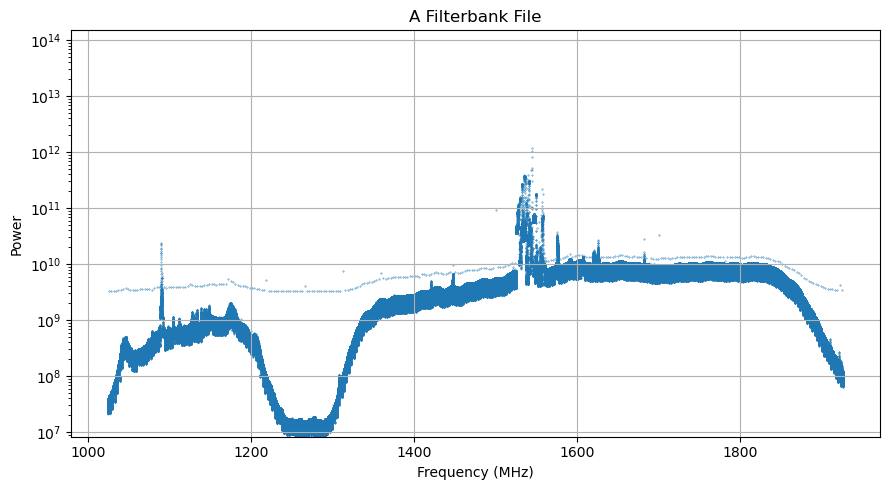

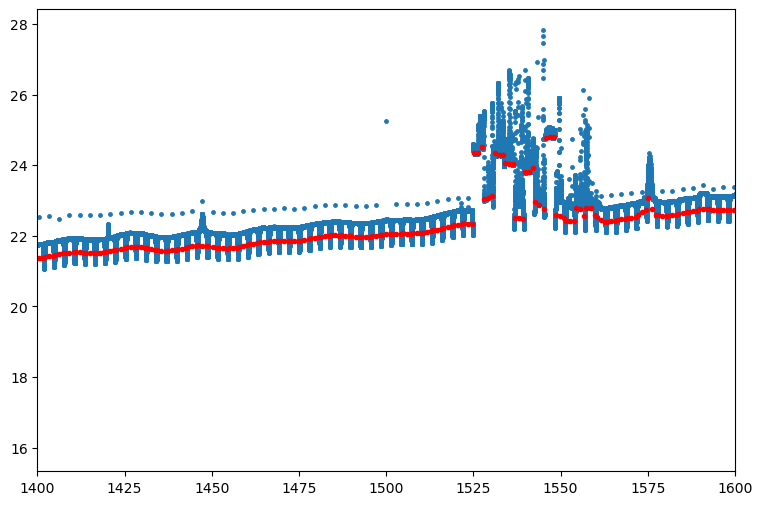

In [44]:
def findline(p1, p2):
    #Returns the slope and intercept of line connecting two given points
    #p1 and p2 must be length-2 iterables containing the (x,y) coordinates
    x1, y1 = p1
    x2, y2 = p2
    m = (y2 - y1)/(x2 - x1) #slope
    b = y1 - m*x1 #intercept
    return m, b

def pad_data(x, y, n_pad = int(5)):
    #Pad data by simply extending a line in both directions with slope given by
    #the two points on each end of the data. n_pad is the no. of points to add on each side
    
    first_two_x = x[0:2]
    first_two_y = y[0:2]
    first_two_points = np.dstack([first_two_x, first_two_y])[0]
    left_m, left_b = findline(first_two_points[0], first_two_points[1]) #slope, intercept for left side

    last_two_x = x[-2:]
    last_two_y = y[-2:]
    last_two_points = np.dstack([last_two_x, last_two_y])[0]
    right_m, right_b = findline(last_two_points[0], last_two_points[1])

    pad_value = np.abs(x[n_pad] - x[0])
    left_pad_x = np.array(x[0:n_pad] - (pad_value))
    left_pad_y = left_m*left_pad_x + left_b
    right_pad_x = np.array(x[-n_pad:] + (pad_value))
    right_pad_y = right_m*right_pad_x + right_b

    padded_x = np.array(list(itertools.chain(left_pad_x, x, right_pad_x)))
    padded_y = np.array(list(itertools.chain(left_pad_y, y, right_pad_y)))

    return padded_x, padded_y

def CC_points(x, y):
    #Create a set of points from each coarse channel, to be used for plotting a spline.
    #x and y are 1-D iterables of equal length. Typically x will be the frequency array
    #and y the power array (of the entire spectrum). 
    x = np.array(x)
    y = np.array(y)
    num_CCs = int(len(x)/1024) #The number of coarse channels, since each one has length 1024
    
    #Make array of integers and split it into however many coarse channels there are
    coarsechans = np.split(np.arange(len(x)), num_CCs)

    yvals = []
    xvals = []
    for chan_idx in coarsechans:
        chanfreqs = x[chan_idx] #Frequencies for this coarse channel
        chanpowers = y[chan_idx] #Power values for this coarse channel
        
        power1 = np.percentile(chanpowers[0:255], 20)
        power2 = np.percentile(chanpowers, 10)
        power3 = np.percentile(chanpowers[-255:], 20)
        
        powers = [power1, power2, power3]
        freqs = np.percentile(chanfreqs, [10,50,90])
        
        for f in freqs:
            xvals.append(f)
        
        for p in powers:
            yvals.append(p)
    
    #To prevent spline from misbehaving at edges, pad with points                                               
    xvals, yvals = pad_data(xvals, yvals)
    return xvals, yvals

xvals, yvals = CC_points(freqs, np.log(data))
plt.figure(figsize=(9,6))

plt.scatter(freqs, np.log(data), linewidth=1.5, zorder=1, s=4)   
for i in np.arange(len(xvals)):
    plt.scatter(xvals[i], yvals[i], zorder=2, color='red', s=9)
plt.xlim(1400,1600)
plt.show(); plt.tight_layout()

<Figure size 640x480 with 0 Axes>

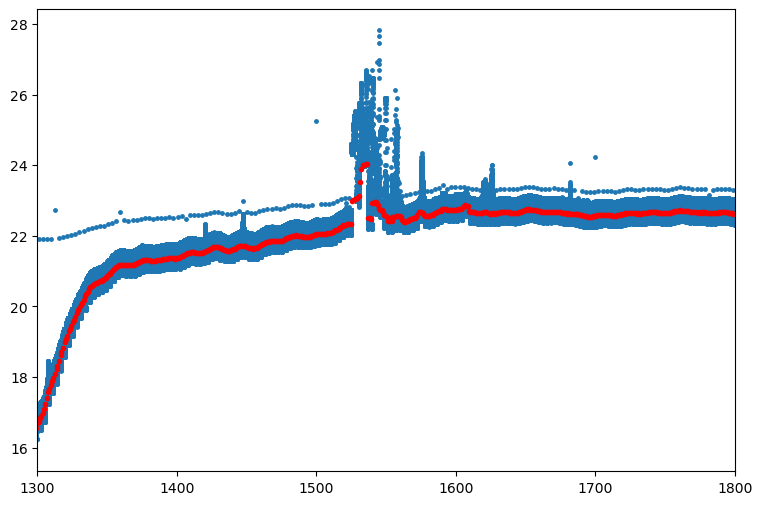

In [45]:
def clean_CC_points(xvals, yvals):
    #Now clean the representative points in each coarse channel, 
    #reject outliers and dragging down their positions                                                                                              
    for i in np.arange(10): #Do this same thing 5 times                                                                                          
        for i in np.arange(1, len(xvals)-1):
            previousp = np.array([xvals[i-1], yvals[i-1]]) #Point on the left
            currentp = np.array([xvals[i], yvals[i]]) #Current points in question
            nextp = np.array([xvals[i+1], yvals[i+1]]) #point on the right
            m, b = findline(previousp, nextp) #slope and intercept of a line connecting left and right points
            interpolatedp = np.array([xvals[i], m*xvals[i]+b]) #what the power level would be if on this line

            #If current actualy point is higher than both of the two on the sides, 
            #and the distance between it and the line connecting the two 
            #is sufficiently large, replace its y value. with the interpolated one
            if (currentp[1] > previousp[1] and currentp[1] > nextp[1]) and \
            currentp[1]-interpolatedp[1] > .01*np.linalg.norm(currentp - previousp) \
            and currentp[1] > interpolatedp[1]:
                #Replace current point with interpolation                                                       
                m, b = findline(previousp, nextp)
                yvals[i] = m*xvals[i]+b
    return xvals, yvals        

xvals, yvals = clean_CC_points(xvals, yvals)

plt.figure(figsize=(9,6))

plt.scatter(freqs, np.log(data), linewidth=1.5, zorder=1, s=4)   
for i in np.arange(len(xvals)):
    plt.scatter(xvals[i], yvals[i], zorder=2, color='red', s=9)
plt.xlim(1300,1800)
plt.show(); plt.tight_layout()

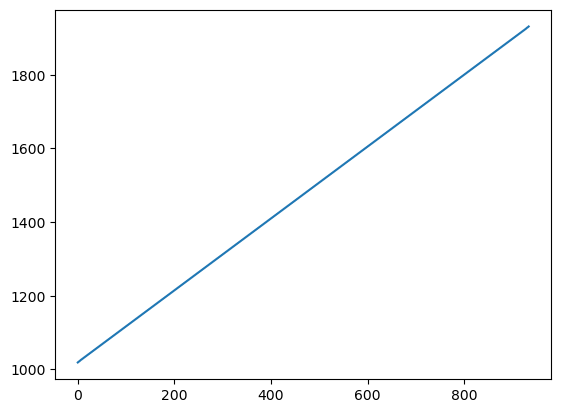

In [46]:
plt.plot(xvals)
plt.show()

In [47]:
from scipy.interpolate import make_splrep
import scipy

%matplotlib inline
def trend_spline(x,y,k=3):
    #x is the frequency array, y is power. k is the order of the polynomials
    #used for the spline.
    initial_x, initial_y = CC_points(x, y)
    cleaned_x, cleaned_y = clean_CC_points(initial_x, initial_y)
    
    #Build spline                                                                                                                               
    N=len(x); rmserror=.00001
    #This just sets the tolerance for how close the spline must be to the given points. s is
    #a parameter that is related to how many nodes there are in the spline.
    spl = make_splrep(cleaned_x, cleaned_y, k=k)
    return cleaned_x, cleaned_y, spl

x, y, spline = trend_spline(freqs, np.log(data))
plt.figure(figsize=(9,6))
plt.scatter(freqs, np.log(data), s=5)
plt.plot(freqs, spline(freqs), color='red', linewidth=2)
plt.xlim(1400,1600)
plt.scatter(x, y, s=12, color='orange', zorder=3); plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

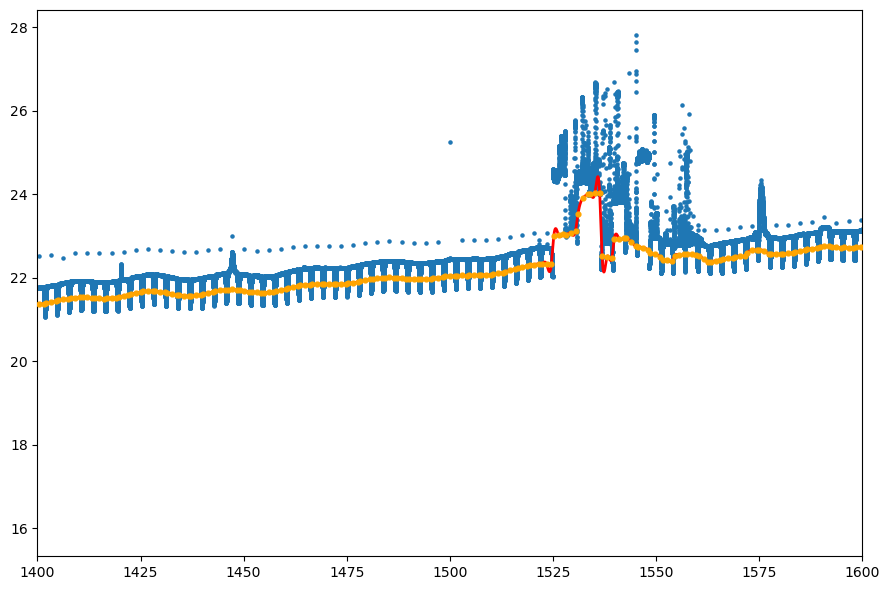

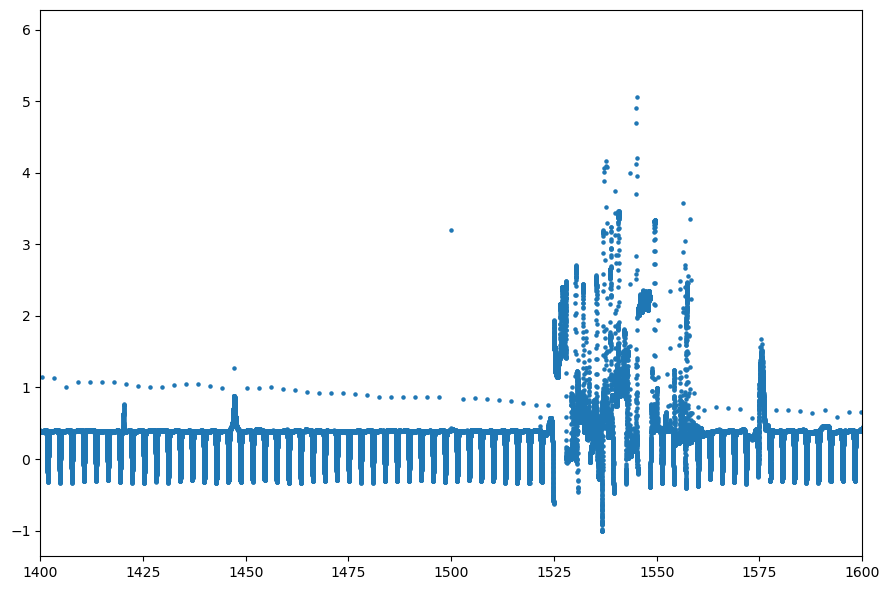

In [48]:
logged_minus_spline = np.log(data) - spline(freqs)
detrended = logged_minus_spline
plt.figure(figsize=(9,6))
plt.scatter(freqs, logged_minus_spline, s=5); 
plt.xlim(1400,1600)
plt.tight_layout()
plt.show()

## Sigma Clipping the Stationary Spectrum

Now that we have the data in a nice stationary form, we are nearly in a position to take advantage of the periodicity and create a fit to the bandpass filter shapes. Before we do that, though, it will be helpful to eliminate the narrow-band features. Now that the spectrum is stationarized, we can eliminate these features with a simple sigma-clipping approach.

We use the `sigma_clip` function from astropy, but with a wrapper function around it. The reason for the wrapper is that `sigma_clip` returns the clipped data in the form of a masked numpy array rather than deleting the clipped values entirely, but it turns out that later parts of our analysis do not play nicely with this mask and act as if the array was never clipped at all. So the purpose of the wrapper is to manually remove the masked values entirely and save the indices of the values that were removed.

In [50]:
%matplotlib inline
def clip(x, y, sigma_lower=5, sigma_upper=.1):
    clipped = sigma_clip(y, sigma_lower=sigma_lower, sigma_upper=sigma_upper) #Determined the 
    #thresholds by trial and error
    rejected = np.ma.getmask(clipped)
    idx_rejected = np.where(rejected)[0] #indices of clipped values
    clipped_data = np.delete(y, idx_rejected)
    clipped_freqs = np.delete(x, idx_rejected)
    return clipped_freqs, clipped_data, idx_rejected
    
clipped_freqs, clipped_data, idx_rejected = clip(freqs, detrended)
plt.figure(figsize=(10,5))
plt.xlim(1425,1450)
plt.scatter(clipped_freqs, clipped_data, s=7)

## Fitting a Fourier Series

The detrended and almost perfectly periodic series of data points that we now have is something that is very easy to work with. What we want to do next is take advantage of the periodicity in the data by coming up with a Fourier series that captures this periodicity. We can save a finite number of the terms in that series and use them to create the same periodic fit to every file, because each one will have the same inherent periodicity once the trend is removed.

So, first we identify a quiet region of this spectrum:

In [52]:
def freq2pix(freq,x):
    h = (x[-1]-x[0])/len(x)
    pix = int((freq - x[0])/h)
    return pix

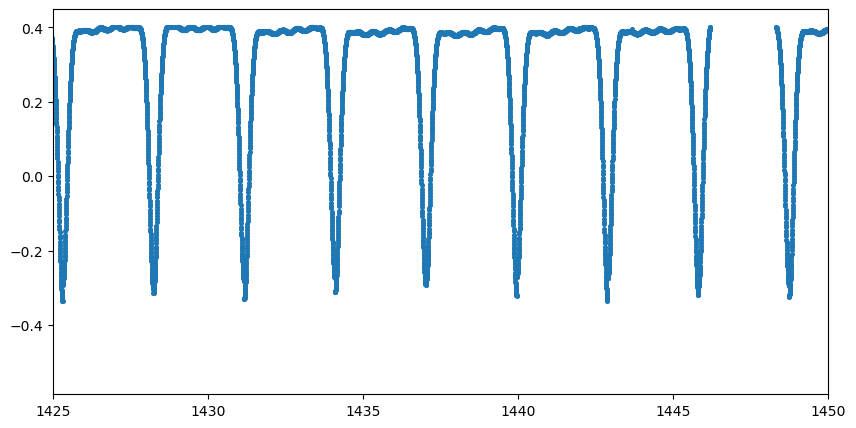

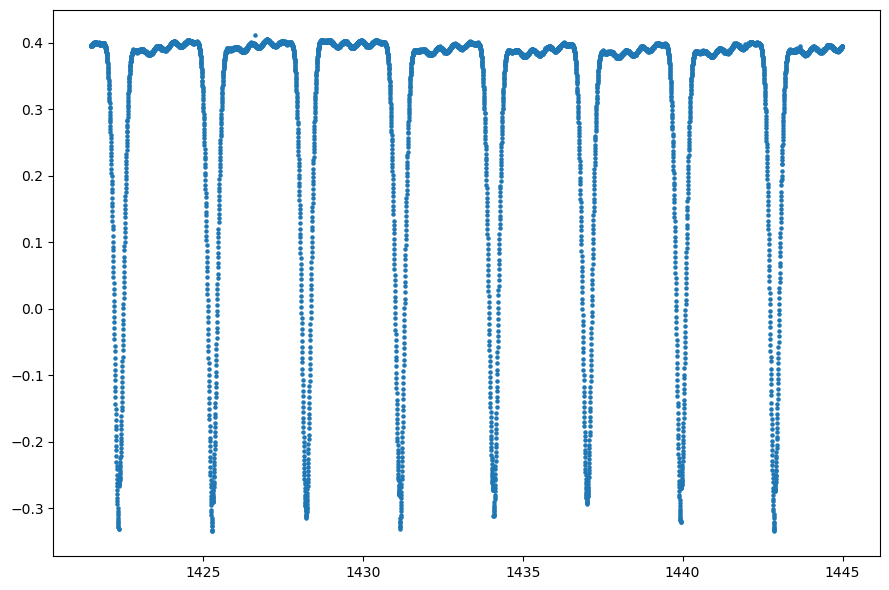

In [53]:
# The far right part of the spectrum looks very quiet and seems promising. 
#So here we choose indices for a coarse channel from that region.
#I chose this specific region by trial and error until I got one that looked as
#quiet as possible

start = freq2pix(1421.5,freqs)
end = freq2pix(1445,freqs) #take 2 coarse channels (each is 1024 frequency bins long)

quiet_section_freqs = freqs[start:end]
quiet_section_powers = detrended[start:end]

#We'll get rid of the DC spikes so they don't interfere with our Fourier decomposition.
#A simple way to do this is to just set those frequency values to have the power values
#associated with the immediately preceding points.
for i in np.arange(len(quiet_section_freqs)):
    if quiet_section_powers[i] > 0.8: #This threshold was determined visually
        quiet_section_powers[i] = quiet_section_powers[i-1] #replace it with previous power value

plt.figure(figsize=(9,6))
plt.scatter(quiet_section_freqs, quiet_section_powers, s=5)
plt.tight_layout()
plt.show()

In [54]:
def fourier_components(x, y, n):
    FFT = np.fft.fft(y)/len(y)
    amplitudes = np.abs(FFT)
    freqs = np.fft.fftfreq(len(y),x[1]-x[0])
    phases = np.array([np.arctan2(item.imag, item.real) for item in FFT])
    
    #take n freqs with largest amplitudes
    max_idx = amplitudes.argsort()[-n:]
    max_freq = freqs[max_idx]
    max_phase = phases[max_idx]
    max_amp = amplitudes[max_idx]
    
    #This creates a list of tuples. Each tuple contains the amplitude, frequency, and phase offset of a
    #single component, i.e. a single term in the series
    params = np.dstack([max_amp, max_freq, max_phase])[0] 
    
    series = np.zeros(len(x)) #Make an array of zeros to which we will add the values from each term
    for i in np.arange(len(max_idx)):
        series += np.array([params[i][0]*np.cos(2*np.pi*params[i][1]*(val) + params[i][2]) for val in x])
    plt.figure(1, figsize=(9,5))
    plt.scatter(x, y, s=6)
    plt.plot(x, series, color='yellow', linewidth=2); plt.tight_layout()
    return params

#I used trial and error to determine to take the 35 highest-amplitude terms
fourier_tuples = fourier_components(quiet_section_freqs, quiet_section_powers, 20)   

In [55]:
with open('fourier_tuples.json', 'w') as f:
    json.dump(fourier_tuples.tolist(), f)

Fitting to a coarse channel to find optimal phase and offset...
The algorithm seems to failed on finding phase offset so adding one part to find better offset ...
Lag of the fit:  0.5
Found phase and offset. Constructing full spectrum Fourier fit...


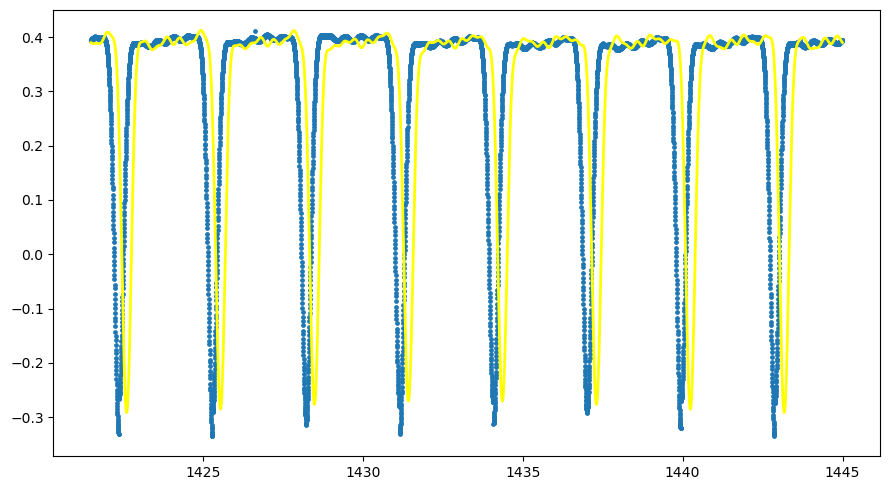

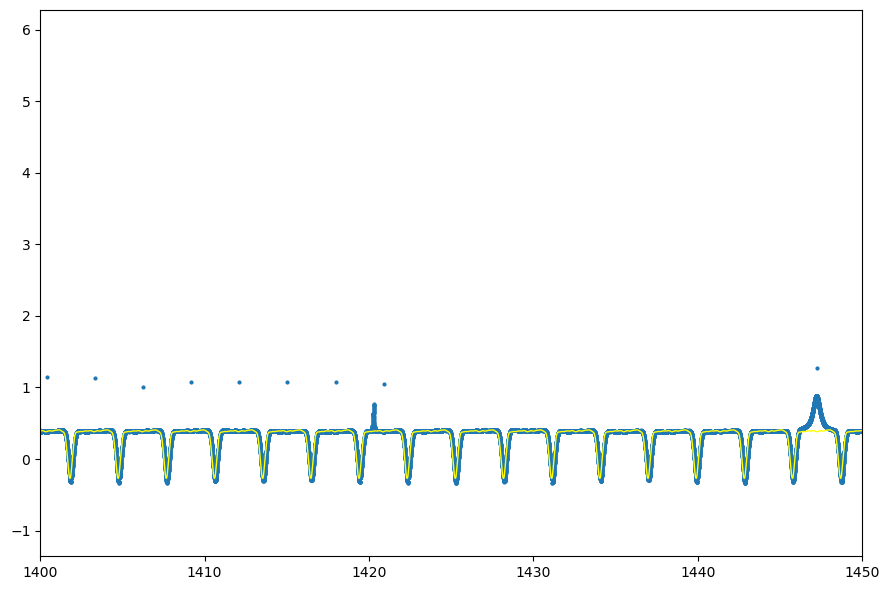

In [56]:
def fourier_fit(freqs, transformed_data):
    #transformed data is the logged, detrended, sigma clipped data.
    num_CCs = int(len(freqs)/1024) #number of coarse channels, since each one
    #is 1024 bins long
    coarsechans = np.split(np.arange(len(freqs)), num_CCs)

    #First find the coarse channel with smallest variance                                                                                                              
    chanvars = []
    for i in np.arange(len(coarsechans)):
        chan = coarsechans[i] #indices
        chanpowers = transformed_data[chan]
        chanvars.append(np.var(chanpowers))
        
    #Extract info for CC with smallest variance   
    quietest_chan_idx = chanvars.index(sorted(chanvars)[0])                                                     
    quietest_chan_powers = transformed_data[coarsechans[quietest_chan_idx]]
    quietest_chan_freqs = freqs[coarsechans[quietest_chan_idx]]
    
    
    
    #We don't want large values to impact the sum of squares and drag up the vertical offset. 
    #So first we sigma clip the data and we will feed the clipped version to the curve fit procedure.

    #This function is here purely for use by scipy.curve_fit
    def CC_fourier_fit(freqs_CC,D):
        #Fit one Fourier period to a quiet coarse channel, use this to determine phase and vertical shift.  
        #freqs_CC is the frequencies of this coarse channel
        fit = np.zeros(len(freqs_CC))
        for i in np.arange(len(fourier_tuples)): #Build Fourier series term-by-term
            fit += np.array([fourier_tuples[i][0]*np.cos(2*np.pi*fourier_tuples[i][1]*(val+D) +\
                                                                    fourier_tuples[i][2]) for val in freqs_CC])
        #fit += np.array([C]*len(freqs_CC)) #Add constant vertical shift
        return np.array(fit)

    print("Fitting to a coarse channel to find optimal phase and offset...")
    parameters = curve_fit(CC_fourier_fit, quietest_chan_freqs, quietest_chan_powers)[0]
    fourier_CC = CC_fourier_fit(quietest_chan_freqs, *parameters)

    print("The algorithm seems to failed on finding phase offset so adding one part to find better offset ...")
    correlation = signal.correlate(fourier_CC, quietest_chan_powers, mode="same")
    lags = signal.correlation_lags(fourier_CC.size, quietest_chan_powers.size, mode="same")
    lag = lags[np.argmax(correlation)] + 0.5
    print("Lag of the fit: ",lag)
    
    fourier_CC_shift = CC_fourier_fit(quietest_chan_freqs - lag, *parameters)
    
    print("Found phase and offset. Constructing full spectrum Fourier fit...")
    #Tile the single-channel fit to get the fit for the entire spectrum
    fourier_fit = np.tile(fourier_CC_shift, len(coarsechans))
    
    return fourier_fit

fit = fourier_fit(freqs, detrended)

#Plot the detrended spectrum and the fit over it

plt.figure(figsize=(9,6))
plt.scatter(freqs, detrended, s=4)
plt.xlim(1400,1450)
plt.plot(freqs, fit, color='yellow', linewidth=1); plt.tight_layout()
plt.show()

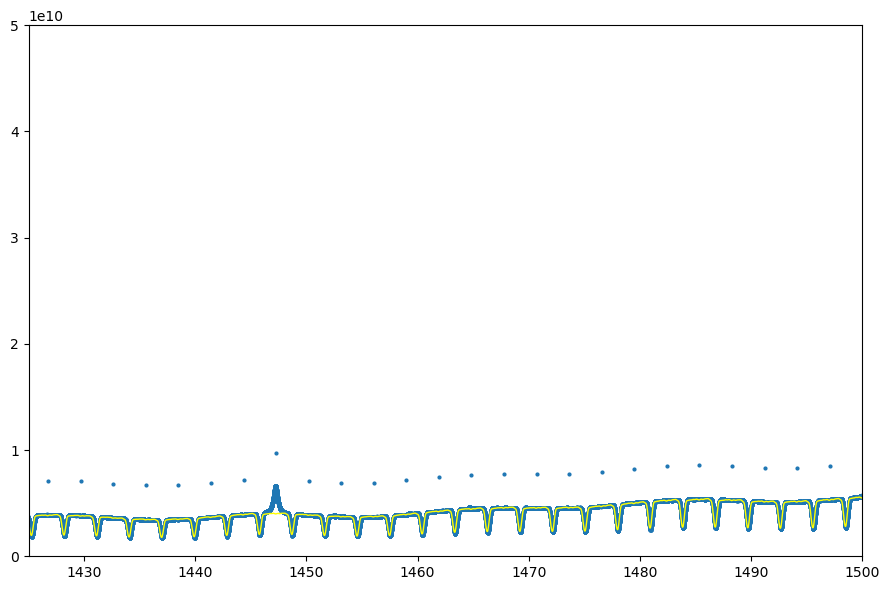

In [100]:
final_fit = np.exp(fit + spline(freqs))

plt.figure(figsize=(9,6))
plt.scatter(freqs, data, s=4)
plt.xlim(1425,1500)
plt.ylim(0,5e10)
plt.plot(freqs, final_fit, color='yellow', linewidth=1); plt.tight_layout()
plt.show()

In [58]:
water_fall = np.array(fil.data)
fit_water_fall = np.zeros_like(water_fall)

for i in range(water_fall.shape[0]):
    fit_water_fall[i,:,:] = np.flip(final_fit)

detrended_waterfall = water_fall - fit_water_fall + 1
print(detrended_waterfall.shape)

(273, 1, 315392)


In [59]:
out = fil
out.data = fit_water_fall
out.freqs = np.flip(freqs)

write_to_fil(out, filename_out = 'Model.' + filename)

blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for Model.spliced_blc0001020304050607_guppi_57571_78180_HIP45653_0042.gpuspec.0002.h5 in one go.
blimpy.waterfall INFO     Conversion time: 0.12sec
